<a href="https://colab.research.google.com/github/jav0927/AI/blob/Experimental/Fastai2_SSD_280_GouAug.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Object Detection in FASTAI2

#### Version Date
J. A Villalobos, @ 2019, 2020, wolves.lair@icloud.com

#### Initialize Google Drive



In [133]:
# Connect Google drive to Colab for file saving and loading.
from google.colab import drive
drive.mount('/content/gdrive')
from google.colab import files

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


#### Load Fastai2 

In [134]:
import os 
!pip install torch==1.6.0+cu101 torchvision==0.7.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html 
!pip install fastai2 --quiet
!pip install nbdev --quiet

Looking in links: https://download.pytorch.org/whl/torch_stable.html


In [135]:
!pip show fastai2

Name: fastai2
Version: 0.0.27
Summary: Version 2 of the fastai library
Home-page: https://github.com/fastai/fastai2
Author: Jeremy Howard, Sylvain Gugger, and contributors
Author-email: info@fast.ai
License: Apache Software License 2.0
Location: /usr/local/lib/python3.6/dist-packages
Requires: fastprogress, packaging, spacy, torch, pyyaml, scikit-learn, fastcore, pillow, scipy, torchvision, pandas, requests, pip, matplotlib
Required-by: 


#### Version Date
J. A Villalobos, @ 2019, 2010, wolves.lair@icloud.com

#### Initialization

In [136]:
# Set up online plotting
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [137]:
#from nbdev import *
#from nbdev.showdoc import *
#from fastcore.test import *

In [138]:
# For use in Auto Augment data transformations
import random
import torchvision.transforms.functional as FT
from typing import *
from PIL import Image, ImageEnhance, ImageOps
import math
import copy

In [139]:
# Import Fastai 2
from fastai2.vision.all import *
#from nbdev.showdoc import *

# Import Torch
import torch
from fastai2 import __version__
print(f'Torch Version: {torch.__version__}')
print(f'Fastai2 Version: {__version__}')

Torch Version: 1.6.0+cu101
Fastai2 Version: 0.0.27


In [140]:
# Automatically sets for GPU or CPU environments
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  

#### Parameters

In [141]:
SEED_VL = 42
SZ = 280
AUG_SZ = 400
BS = 32
PROG_RESIZES = {128:3, 224: 1, 280: 0}  # These are permissible values for the parameter.
PROG_RESIZE = {280: 0}                  # Choose one of them

# Architecture
ARCH = xresnet50

#focal loss parameters (as per th paper)
ALPHA = 0.25
GAMMA = 2    

#### Download Pascal 2007

In [142]:
ds_source = untar_data(URLs.PASCAL_2007)

In [143]:
Path.BASE_PATH = ds_source # display all paths relative to dataset root
ds_source.ls()

(#8) [Path('train'),Path('test.csv'),Path('train.csv'),Path('test'),Path('train.json'),Path('valid.json'),Path('test.json'),Path('segmentation')]

#### Data Preparation

In [144]:
# Compile the data used for training and validation
# Collect image names, bound box coordinates, and categories into lists
# for train and test data sets
trn_img_names, trn_truths = get_annotations(ds_source/'train.json')
val_img_names, val_truths = get_annotations(ds_source/'valid.json')
tst_img_names, tst_truths = get_annotations(ds_source/'test.json') 

# Combine Train and Validation set into a sigle dataset
# (which will be split later by the data block)
tot_img_names, tot_truths = [trn_img_names + val_img_names, trn_truths + val_truths]

# Create a dictionary containing the composite of the above
get_x_y = dict(zip(tot_img_names, tot_truths))

#### Apply Google's AutoAugment Policy

##### BoundingBox transformations

In [145]:
# HELPER FUNCTIONS
def fastai2pil_basis(b) :  return ((b + 1.)).div(2.)      # Convert to PIL image basis (0,0) to (1,1)         
def pil2fastai_basis(b):  return (b * 2.).float() - 1.    # Convert to FASTAI image basis. (-1,-1) to (1,1) 
def flip_horizontal(bboxes):                              # This method flips a negative transformation into positive one, thus avoiding coding complexity
  bboxes[:,[1,3]] = torch.flip(bboxes[:,[1,3]], [1])      # Swap the (x) columns: 1, and 3
  bboxes[:,[1, 3]] *= -1;                                 #   Flip the sign of each of these columns
  return bboxes
def swap_xy_coords (bboxes):                                 # swap yx coordinate sequences in bounding boxes into xy sequences, and viceversa
  #bboxes[:,([0,2],[1,3])] = torch.flip(bboxes[:,([0,2],[1,3])], [1]) 
  bboxes[:,[0,1]] = torch.flip(bboxes[:,[0,1]], [1]) 
  bboxes[:,[2,3]] = torch.flip(bboxes[:,[2,3]], [1])
  return bboxes
def rotate_bb(bc, rads):            
    M = torch.tensor([                         # Rotation Matrix
           [math.cos(rads), -math.sin(rads)],         
           [math.sin(rads),  math.cos(rads)]
           ] ).to(device)           
    return torch.mm(M,bc.to(device))           #  Rotate bounding box, as given by "degrees"   


# SHEAR-HORIZONTALLY BOUNDING BOXES
def shear_x_bboxes (bboxes, factor, y_first=True):
  ''' 
    Shear horizontally a set of bounding boxes corresponding to a given image
          bboxes :      A set of bounding boxes associated with the image
          factor :      Factor by which the image in sheared in the X direction
  '''
  if not y_first: swap_xy_coords(bboxes)                                # swap yx sequence for xy sequence
  m = bboxes[(bboxes == 0.).all(1)]                                     # Retain the all-zero rows
  bboxes = bboxes[~(bboxes == 0.).all(1)]                               # Retain the non all-zero rows
  mag = factor                                                          # If the factor is negative, flip the boxes about the (0,0) center
  if factor <= 0 : mag = -factor; bboxes = flip_horizontal(bboxes)      # so it can be sheared correctly (in the positive orientation)
  bboxes = fastai2pil_basis(bboxes)                                     # Convert to PIL image basis (0,0) to (1,1)       
  bboxes[:,[1,3]] = bboxes[:,[1,3]] + bboxes[:,[0,2]]  * mag            # Shear in the horizontal direction (to the right)
  bboxes = pil2fastai_basis(bboxes)                                     # Convert to FASTAI image basis. Top-left (-1,-1) to Bottom-right (1,1)
  if factor <= 0 : bboxes = flip_horizontal(bboxes)                     # If factor is negative, restore the boxes to the original orientation
  bboxes = torch.clamp(bboxes, -1, 1)                                   # Clamp coordinates to [-1, 1]
  bboxes = torch.cat([m, bboxes], dim=0)                                # Graft the all-zero rows back to the bounding box array    
  if not y_first: swap_xy_coords(bboxes)                                # restore xy sequence
  return bboxes


# ROTATE BOUNDING BOXES
def rotate_bboxes(bboxes, degrees, y_first=True):
  ''' 
    Create a bounding Box for a rotated image
        bboxes :        A single bounding box
        degrees :       Angle in degrees to rotate the image
  '''
  rads = math.radians(degrees)                                          # Convert degrees to radians   
  if not y_first: swap_xy_coords(bboxes)                                # swap yx sequence for xy sequence
  m = bboxes[(bboxes == 0.).all(1)]                                     # Retain the all-zero rows of the bounding box
  bboxes = bboxes[~(bboxes == 0.).all(1)]                               # Retain the non all-zero rows of the bounding box
  lgt = abs(bboxes[:,[1]] - bboxes[:,[3]])                              # Calculate the length of the box in the x axis
  mag = rads                                                            # If degrees is negative, flip the boxes about the (0,0) center
  if degrees <= 0 : mag = -rads; bboxes = flip_horizontal(bboxes)       # so it can be rotated correctly (in the positive orientation)
  bboxes = bboxes.reshape(-1,2).transpose(1,0)                          # Put tensor into a (n x 2) vertical array
  bboxes = rotate_bb(bboxes, mag).transpose(0,1).reshape(-1,4)          # Rotate bounding box and restore coordinates to fastai image basis 

  bboxes [:,[0]] = bboxes [:,[0]] - (lgt)*math.sin(mag)                 # Calculate the delta-lenght to add and substract to 
  bboxes [:,[2]] = bboxes [:,[2]] + (lgt)*math.sin(mag)                 #   the y coordinates to compensate for the rotation
  if degrees <= 0 : bboxes = flip_horizontal(bboxes)                    # If degrees is negative, restore the boxes to the original orientation
  bboxes = torch.clamp(bboxes, -1, 1)                                   # Clamp coordinates to [-1, 1]

  bboxes = torch.cat([m, bboxes], dim=0)                                # Graft the all-zero rows back to the bounding box array
  if  not y_first: swap_xy_coords(bboxes)                               # Restore xy sequence
  return bboxes

##### Data Augmentation Algorithm

In [146]:
# Helper Function
#TODO: replace it with Fastai2 transform
def pil2tensor(image:PILImage,dtype:np.dtype)->TensorImage:
    "Convert PIL style `image` array to torch style image tensor."
    a = np.asarray(image)
    if a.ndim==2 : a = np.expand_dims(a,2)
    a = np.transpose(a, (1, 0, 2))
    a = np.transpose(a, (2, 1, 0))
    return torch.from_numpy(a.astype(dtype, copy=False) )

# ImageNet Policy
class ImageNetPolicy():
    '''
    Augmentation policy for the ImageNet Dataset.
    (According to the paper Learning Data Augmentation Strategies for Object detection. Barret Zoph, et. al. 6/26/2019)
    The Policy is composed of a series of sub-policies. 
    Each sub-policy contains two (2) augmentation steps. i. e. 'posterize', 'rotate'
    Each step consists of:
          (1) an operation i.e. 'posterize', 
          (2) probability of application. i.e. 0.4, and
          (3) magnitude indicating the intensity of the operation
    Author:  J. Adolfo Villalobos @ 2020 
    '''
    def __init__(self, fillcolor=(128, 128, 128)):
        
        self.policy = [
            SubPolicy("posterize", 0.4, 8, "rotate",       0.6, 9, fillcolor),
            SubPolicy("solarize",  0.6, 5, "autocontrast", 0.6, 5, fillcolor),
            SubPolicy("equalize",  0.8, 8, "equalize",     0.6, 3, fillcolor),
            SubPolicy("posterize", 0.6, 7,"posterize",     0.6, 6, fillcolor),
            SubPolicy("equalize",  0.4, 7,"solarize",      0.2, 4, fillcolor),

            SubPolicy("equalize",  0.4, 4, "rotate",       0.8, 8, fillcolor),
            SubPolicy("solarize",  0.6, 3, "equalize",     0.6, 7, fillcolor),
            SubPolicy("posterize", 0.8, 5, "equalize",     1.0, 2, fillcolor),
            SubPolicy("rotate",    0.2, 3, "solarize",     0.6, 8, fillcolor),
            SubPolicy("equalize",  0.6, 8, "posterize",    0.4, 6, fillcolor),

            SubPolicy("rotate",    0.8, 8, "color",        0.4, 0, fillcolor),
            SubPolicy("rotate",    0.4, 9, "equalize",     0.6, 2, fillcolor),
            SubPolicy("equalize",  0.0, 7, "equalize",     0.8, 8, fillcolor),
            SubPolicy("invert",    0.6, 4, "equalize",     1.0, 8, fillcolor),
            SubPolicy("color",     0.6, 4, "contrast",     1.0, 8, fillcolor),

            SubPolicy("rotate",    0.8, 8, "color",        1.0, 2, fillcolor),
            SubPolicy("color",     0.8, 8, "solarize",     0.8, 7, fillcolor),
            SubPolicy("sharpness", 0.4, 7, "invert",       0.6, 8, fillcolor),
            SubPolicy("shearX",    0.6, 5, "equalize",     1.0, 9, fillcolor),
            SubPolicy("color",     0.4, 0, "equalize",     0.6, 3, fillcolor),

            SubPolicy("equalize",  0.4, 7, "solarize",     0.2, 4, fillcolor),
            SubPolicy("solarize",  0.6, 5, "autocontrast", 0.6, 5, fillcolor),
            SubPolicy("invert",    0.6, 4, "equalize",     1.0, 8, fillcolor),
            SubPolicy("color",     0.6, 4, "contrast",     1.0, 8, fillcolor),
            SubPolicy("equalize",  0.8, 8, "equalize",     0.6, 3, fillcolor)
        ]
            
    
    def __call__(self, x, y):
      '''Fetch a random sub-policy'''
      policy_idx = random.randint(0, len(self.policy) - 1)
      return self.policy[policy_idx](x, y)

    def __repr__(self):
        return "AutoAugment Policy Applicable to the ImageNet Dataset. " 
 
# ********************************

class SubPolicy():
    def __init__(self, operation1, p1, magnitude_idx1, operation2, p2, magnitude_idx2, fillcolor=(128, 128, 128)):
        '''
        The magnitude that is specified for each subpolicy item is a number from 1 to 10.
        This number translates to a separate measure which varies for each operation. The specific measure
        is picked up from a range of uniformly spaced physical attribute values according to the dictionary below.
        '''
        ranges = {
            "shearX": np.linspace(-0.3, 0.3, 10),     
            "shearY": np.linspace(-0.3, 0.3, 10),     
            "translateX": np.linspace(-150, 150 / 331, 10),
            "rotate": np.linspace(-30, 30, 10),        
            "color": np.linspace(0.1, 1.9, 10),
            "posterize": np.round(np.linspace(8, 4, 10), 0).astype(np.int),
            "solarize": np.linspace(256, 0, 10),
            "contrast": np.linspace(0.1, 1.9, 10),
            "sharpness": np.linspace(0.1, 1.9, 10),
            "brightness": np.linspace(0.1, 1.9, 10),
            "autocontrast": [0] * 10,
            "equalize": [0] * 10,
            "invert": [0] * 10
        }
       
        # Custom rotate with fill       
        def rotate_with_fill(img:PILImage, yb, mag):
            ob = rotate_bboxes(yb, mag, y_first=False)
            #rot = img.convert("RGBA").rotate(mag,fillcolor=(128,128,128))    # Rotate the image
            #return [Image.composite(rot, Image.new("RGBA", rot.size, (128,) * 4), rot).convert(img.mode), ob]
            return [img.convert("RGBA").rotate(mag, resample=Image.BICUBIC, fillcolor=(128,128,128)).convert(img.mode), ob]    # Rotate the image

        def shear_horizontal (img:PILImage, yb, mag): 
            trb = mag*random.choice([-1, 1])
            tri = (1, -trb, 0, 0, 1, 0)
            b_tf = img.transform(img.size, Image.AFFINE, tri, Image.BICUBIC,fillcolor=(128,128,128) )
            ob = shear_x_bboxes (yb, trb, y_first=False)                 
            return [b_tf, ob]

        # Transform functions
        func = {

            "rotate": lambda img, yp, magnitude: rotate_with_fill(img, yp, magnitude),
            "shearX": lambda img, yp, magnitude: shear_horizontal(img, yp, magnitude), 
            "color": lambda img, yp, magnitude: [ImageEnhance.Color(img).enhance(magnitude), yp],
            "posterize": lambda img, yp, magnitude: [ImageOps.posterize(img, magnitude), yp],
            "solarize": lambda img, yp, magnitude: [ImageOps.solarize(img, magnitude), yp],
            "contrast": lambda img, yp, magnitude: [ImageEnhance.Contrast(img).enhance(
                1 + magnitude * random.choice([-1, 1])), yp],
            "sharpness": lambda img, yp, magnitude: [ImageEnhance.Sharpness(img).enhance(
                1 + magnitude * random.choice([-1, 1])), yp],
            "brightness": lambda img, yp, magnitude: [ImageEnhance.Brightness(img).enhance(
                1 + magnitude * random.choice([-1, 1])), yp],
            "autocontrast": lambda img, yp, magnitude: [ImageOps.autocontrast(img), yp],
            "equalize": lambda img, yp, magnitude: [ImageOps.equalize(img, mask=None), yp],
            "invert": lambda img, yp, magnitude: [ImageOps.invert(img), yp]
        }
        
        
        # Probabilities
        self.p1 = p1; self.p2 = p2
        
        #  Fetch a Fastai transform corresponding to the given subpolicy step operation
        self.operation1 = func[operation1]; self.operation2 = func[operation2]
        self.magnitude1 = ranges[operation1][magnitude_idx1]; self.magnitude2 = ranges[operation2][magnitude_idx2]
        
    # Randomized filtering
    def __call__(self, x, y):       
         # Tensor to PIL image
        img = FT.to_pil_image(x.data.cpu(), mode='RGB')     
        # Fetch a Fastai-formatted transform corresponnding to the given Subpolicy
        if random.random() < self.p1: img, y = self.operation1(img, y, self.magnitude1)
        if random.random() < self.p2: img, y = self.operation2(img, y, self.magnitude2)
        img = pil2tensor(img, dtype=np.float32) #.div(255)  Revert to FASTAI Image format   
        return img, y      # returns the transformed image and    corresponding bounding boxes
       

##### Data Block Interface

In [147]:

class Google_aug (ItemTransform): 
  #Interface between the Google AutoAugmentation  and bach_itfms 
  split_idx = 0 
  def __init__ (self, p=1.0, **kwargs):
    self.policy = ImageNetPolicy()

  def __call__(self, b, split_idx=0):
    #if self.once: print(b[0]); self.once=False
    if split_idx == 0:
        #Interface between the Google AutoAugmentation  and bach_itfms 
        for i in range (b[0].shape[0]):   
          # Aply a random subpolicy to each image in the batch         
          new_input = self.policy(b[0][i], b[1][i])
          new_img, new_bboxes = new_input
          # update image and bboxes into the batch
          b[0][i] = new_img #TensorImage
          b[1][i] = new_bboxes #BBox
          #b[2][i] = b[2][i]  #Categories (Not touched by the transform)
        
        return b  
    else:
        return b


#### Create Image DataLoaders

In [148]:
def get_data(d_bs, d_sz, p_sz):  
  data = DataBlock( blocks=(ImageBlock, BBoxBlock, BBoxLblBlock),
      get_items = get_image_files,
      splitter = RandomSplitter( valid_pct=0.2, seed=SEED_VL),
      getters=[noop, lambda o: get_x_y[o.name][0], lambda o: get_x_y[o.name][1]],
      item_tfms = [Resize(p_sz, method=ResizeMethod.Squish)],               
      batch_tfms = [Google_aug(), Normalize.from_stats(*imagenet_stats, cuda=True), AffineCoordTfm(size=d_sz)] ,
      n_inp=1)

  return data.dataloaders( ds_source/'train', bs=d_bs), data  

In [149]:
 dlrs, data = get_data(BS, SZ, AUG_SZ)

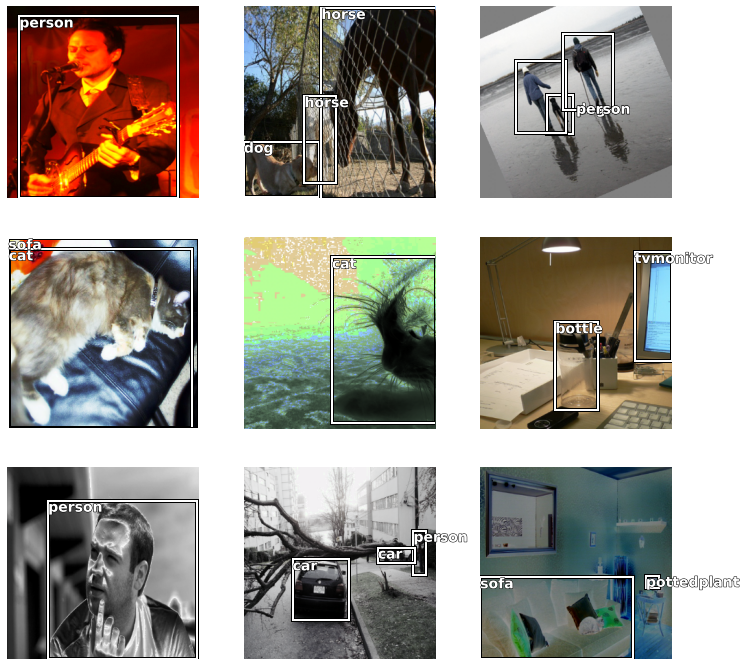

In [150]:
dlrs.show_batch(figsize=(12,12), max_n=9)

In [151]:
data.summary(ds_source/'train')

Setting-up type transforms pipelines
Found 5011 items
2 datasets of sizes 4009,1002
Setting up Pipeline: PILBase.create
Setting up Pipeline: get_data.<locals>.<lambda> -> TensorBBox.create
Setting up Pipeline: get_data.<locals>.<lambda> -> MultiCategorize -- {'vocab': (#21) ['#na#','aeroplane','bicycle','bird','boat','bottle','bus','car','cat','chair'...], 'add_na': True}

Building one sample
  Pipeline: PILBase.create
    starting from
      /root/.fastai/data/pascal_2007/train/004237.jpg
    applying PILBase.create gives
      PILImage mode=RGB size=500x375
  Pipeline: get_data.<locals>.<lambda> -> TensorBBox.create
    starting from
      /root/.fastai/data/pascal_2007/train/004237.jpg
    applying get_data.<locals>.<lambda> gives
      [[226, 158, 500, 375], [0, 2, 169, 375], [131, 137, 266, 333]]
    applying TensorBBox.create gives
      TensorBBox of size 3x4
  Pipeline: get_data.<locals>.<lambda> -> MultiCategorize -- {'vocab': (#21) ['#na#','aeroplane','bicycle','bird','boat',

#### Helper Functions for Predictor Methods

In [152]:
# Helper Functions for Predictor Methods
def ctrhw2tlbr(boxes:Tensor, set_if_input_is_CxCyWH=False):
  ''' Convert box coordinates from CTRHW to x1, y1, x2, y2 formats
      IMPORTANT: The method expects the input boxes tensor to be in CxCyHW.               
      Inputs:
          Boxes        - torch.tensor of activation bounding boxes
          Dim  -         (batch size, Items in batch, 4)
          Input Format - Center coord, height, width

      Output:
          torch.tensor of activation bounding boxes
          Dim = (batch size, Items in batch, 4)
          Format: x1, y1, x2, y2
          '''
  if set_if_input_is_CxCyWH: boxes = boxes[:,:,[0,1,3,2]]                    # Adjust the format to CxCyHW (height, width). This is the FASTAI format 

  x1 = (boxes[:,:,0] - torch.true_divide(boxes[:,:,3],2.)).view(-1,1)
  x2 = (boxes[:,:,0] + torch.true_divide(boxes[:,:,3],2.)).view(-1,1)
  y1 = (boxes[:,:,1] - torch.true_divide(boxes[:,:,2],2.)).view(-1,1)
  y2 = (boxes[:,:,1] + torch.true_divide(boxes[:,:,2],2.)).view(-1,1)
  
  return torch.cat([x1,y1,x2,y2],dim=1)


def tlbr2cthw(boxes:Tensor, ctrhw=True):
  '''Convert top/left bottom/right format `boxes` to center/size corners.
      Input: 
          boxes - torch.Tensor of activations bounding boxes
                  Unbounded
                  Dim = (batch size, Items in batch, 4)
                  Format: top left xy, bottom right xy
          ctrhw =  True -  Output is in the format CxCyHW
                   False - Output is in the format CxCyWH
      Output:
                  torch.tensor of activation bounding boxes 
                  Dim = (batch size, Items in the batch, 4)
                  Format: center coord xy, height, width'''
  center = torch.true_divide(boxes[:,:, :2] + boxes[:,:, 2:], 2)                     # Calculate box center coord
  sizes = torch.abs(boxes[:,:, 2:] - boxes[:,:, :2])                # Calculate box width & height                                         # 
  results = torch.cat( (center, sizes), 2)
  if ctrhw: results = results[:,:,[0,1,3,2]]                        # The correct FASTAI Size format is CxCyHW (height, width)

  return results


# We apply Decoding With Variance to both activation boxes and anchor boxes to calculate the final bounding boxes. 
def activ_decode(p_boxes:Tensor, anchors:Tensor):
  ''' Decodes box activations into final bounding boxes by calculating predicted anchor offsets, which are then added to anchor boxes
        Input:
            p_boxes - torcht.tensor of activation bounding boxes
                      dim:    (batch, items in batch, 4)
                      Format: top left xy, bottom right xy
        Output:
                      torcht.tensor with anchor boxes offset by box activations
                      dim:    (batch, tems in batch, 4)
                      Format: top left xy, bottom right xy'''

  sigma_xy, sigma_hw = torch.sqrt(torch.tensor([0.1])), torch.sqrt(torch.tensor([0.2]))       # Variances for center and hw coordinates

  pb = torch.tanh( p_boxes)                 # Set activations into [-1,1] basis (as used in Fastai) 
 
  ctrwh = tlbr2cthw(pb, ctrhw=False)        # Transform box activations from xyxy format to CxCyWH format. 

  # Calculate offset centers. The sequence is Xp, followed by Yp
  offset_centers = ctrwh[:,:,[0,1]].to(device) * sigma_xy.to(device) * anchors[:,[2,3]].to(device)  + anchors[:,[0,1]].to(device)

  # Calculate offset sizes. The sequence is Wp, followed by Hp
  offset_sizes =  torch.exp(ctrwh[:,:,[2,3]].to(device) *sigma_hw.to(device)).to(device) *anchors[:,[2,3]].to(device)
 
  # Return format to CxCyHW and then return, switching back to X1Y1X2Y2 format.
  return torch.clamp(ctrhw2tlbr(torch.cat([offset_centers, offset_sizes], 2), set_if_input_is_CxCyWH=True).view(*p_boxes.shape), min=-1, max=+1)


# Transform activations into final bounding boxes by calculating the predicted offsets to the anchor boxes
def activ_encode(p_boxes:Tensor, anchors:Tensor):
  ''' Transforms activations into final bounding boxes by calculating predicted anchor offsets, which are then added to the anchor boxes
        Input:
            p_boxes - torcht.tensor of activation bounding boxes
                      dim:    (batch, items in batch, 4)
                      Format: top left xy, bottom right xy
        Output:
                      torch.tensor 
  '''
  sigma_ctr, sigma_hw = torch.sqrt(torch.tensor([0.1])), torch.sqrt(torch.tensor([0.2]))         # Variances
  pb = torch.tanh( p_boxes)                 # Set activations into the basis [-1,1] (as used in Fastai)  pb = torch.tanh(p_boxes[...,:] ) 
  to_ctrwh = tlbr2cthw(pb, tlbr=False)      # Transform activaions from xyxy format to ctrwh format. This will facilitate offset calculations below
  
  # Calculate anchors with offsets to serve as predicted bounded boxes
  offset_center = sigma_ctr * (to_ctrwh[:,:,[0,1]].to(device) - anchors[:,[0,1]].to(device)) / anchors[:,[2,3]].to(device)
  offset_size = torch.log(to_ctrwh[:,:,[2,3]].to(device)/anchors[:,[2,3]].to(device)) / sigma_hw
  centers = anchors[:,[0,1]].to(device) + offset_center.to(device)
  sizes =   anchors[:,[2,3]].to(device) + offset_size.to(device)

  return cthw2corners(torch.cat([centers, sizes], 2))

# Strip zero-valued rows from a bounding box tensor
def strip_zero_rows(bboxes:Tensor):
  ''' Strip zero-valued rows from a bounding box tensor 
      Input:  bboxes   Bounding boox tensor '''
  b_out = []; z_out = []
  for rw in range(bboxes.shape[0]):
      cc = bboxes[rw,0:][~(bboxes[rw,0:] == 0.).all(1)]                               # Retain the non all-zero rows of the bounding box  
      b_out.append(cc) 
      zz = bboxes[rw,0:][(bboxes[rw,0:] == 0.).all(1)]                                # Retain the all-zero rows of the bounding box  
      z_out.append(zz)

  return (b_out, z_out)

# Graft the all-zero rows back to the bounding box array
def graft_zerorows_to_tensor(bboxes:Tensor, zboxes:Tensor):
  ''' Graft the all-zero rows back to the bounding box row(s) 
      Input  bboxes   Bounding boox tensor  
             zboxes   Tensor containing the zero-valued rows stripped by strip_zero_rows function'''
  #bboxes.unsqueeze_( dim=0)
  return torch.cat([bboxes, zboxes], dim=1)  

# Flip a bounding box along the x axis
def flip_on_y_axis(bboxes:Tensor):                              
    ''' Flip a bounding box along the x axis 
        Input:   bboxes   Bounding boox tensor '''
    return bboxes[...,[2,1,0,3]]*torch.tensor([-1.,1.,-1.,1.]).to(device) 

# Flip a bounding box along the x axis
def flip_on_x_axis(bboxes:Tensor):                              
    ''' Flip a bounding box along the x axis 
        Input:   bboxes   Bounding boox tensor '''
    return bboxes[...,[0,3,2,1]]*torch.tensor([1.,-1.,1.,-1.]).to(device) 

def rotate_90_plus(bb:Tensor):
  ''' Rotate bounding box(s) by 90 degrees clockwise
      Input:   bboxes   Bounding boox tensor '''
  return bb[...,[3,0,1,2]]*torch.tensor([-1.,1.,-1.,1.]).to(device)

def rotate_90_minus(bb:Tensor):
  ''' Rotate bounding box(s) by 90 degrees counterclockwise
      Input:   bboxes   Bounding boox tensor '''
  return bb[...,[1,2,3,0]]*torch.tensor([1.,-1.,1.,-1.]).to(device)

def fake_na_boxes (bb:Tensor):
  ''' Changes the zero-value box rows into tinyboxes in order to eliminate the spurious 'na' boxes in show_results '''
  bbr, zer = strip_zero_rows(bb)                                       # split valued rows and zero-value rows 
  zer = [z + torch.tensor([-0.01, -0.01, 0.01, 0.01]).to(device) for z in zer]    # Change zero-valued rows to fake box dimension
  out = [torch.cat([bb, zr], dim=0) for bb, zr in iter(zip(bbr, zer))]           # Reconstitute value rows and fake rows
  return torch.stack(out,0)

#### Helper Functions for Training Methods

In [153]:
# Filter out bounding-box and label entries that have all-zero values VERIFIED SYMETRICAL
def un_pad(boxes,labels):
    bb_keep = ((boxes[:,2] - boxes[:,0])>0).nonzero()[:,0]
    return boxes[bb_keep],labels[bb_keep]
    #return boxes[~(boxes == 0.).all(1)], labels[~(labels == 0).all(1)]  

# Calculate bounding box area  VERIFIED SYMETRICAL
def box_area(boxes):  
    return (boxes[:,2] - boxes[:,0]) * (boxes[:,3] - boxes[:,1])

# Calculate the intersection of two given bounding boxes  VERIFIED SYMETRICAL
def intersect(box_a,box_b):
    # Make sure box_a and box_b exists, otherwise function fails
    top_left = torch.max(box_a[:,None,:2],box_b[None,:,:2])
    top_right = torch.min(box_a[:,None,2:],box_b[None,:,2:])
    inter = torch.clamp((top_right - top_left),min=0)
    return inter[:,:,0] * inter[:,:,1]

# Calculate Jaccard (IOU)   VERIFIED SYMETRICAL
def iou(bbox,anchor):
    #bbox is gt_bb, anchor is anchor box, all in fastai style
    if len(bbox.shape) == 1: bbox = bbox[None,...]  # If bbox is empty i.e. [], force it to be of shape (1,0)
    inter = intersect(bbox,anchor)
    union = box_area(bbox).unsqueeze(dim=1) + box_area(anchor).unsqueeze(dim=0) - inter # To broadcast shape to (N,16),where N is number of gt_bb for single image
    return inter / union

# Convert box from center/height/width format to fastai top-left and bottom-right coordinate format
# NOTE: The Fastai1 convention for center and offset notaion is: c_y, c_x, h, w. We will maintain this convention
# here and in Anchorbox generation. To accomodate this convention in Fastai2, we will flip the incoming bounding box coordinates from xy to yx
def cthw2corners(boxes):
    top = (boxes[:,0] - boxes[:,2]/2).view(-1,1)
    left = (boxes[:,1] - boxes[:,3]/2).view(-1,1)
    bottom = (boxes[:,0] + boxes[:,2]/2).view(-1,1)
    right = (boxes[:,1] + boxes[:,3]/2).view(-1,1)
    return torch.cat([top,left,bottom,right],dim=1)

# Transform activations to bounding box format (center, h, w)  VERIFIED NON-SYMETRIC

# Transform activations to bounding box format (center, h, w)  VERIFIED NON-SYMETRIC
def act_to_bbox(activation, anchor):
    activation = torch.tanh(activation) #force scale to be -1,1
    # Calculate the activation's center
    act_center = anchor[:,:2] + (activation[:,:2]/2 * grid_sizes.float().to(activation.device))    
    # Convert activation to height x width
    act_hw = anchor[:,2:] * (activation[:,2:]/2 + 1)
    return cthw2corners(torch.cat([act_center,act_hw],dim=1))

def activ_to_bbox(acts, anchors, flatten=True):
    "Extrapolate bounding boxes on anchors from the model activations."
    if flatten:
        acts.mul_(acts.new_tensor([[0.1, 0.1, 0.2, 0.2]])) #Can't remember where those scales come from, but they help regularize
        centers = anchors[...,2:] * acts[...,:2] + anchors[...,:2]
        sizes = anchors[...,2:] * torch.exp(acts[...,:2])
        return torch.cat([centers, sizes], -1)
    else: return [activ_to_bbox(act,anc) for act,anc in zip(acts, anchors)]
    return res

#### Helper Functions

In [154]:
def save_file(f, name:Text):
  with open(F'/content/gdrive/My Drive/' + name, 'wb') as fp:
    pickle.dump(f, fp)
    print ('Done')

def load_file(name:Text):
  # Read Data Classes for use in predicting external images
  with open(F'/content/gdrive/My Drive/' + name, 'rb') as fp:
    return pickle.load(fp)

#### Inference - Filtering and NMS

In [155]:
import torchvision      # Needed to invoke torchvision.ops.mns function

# Pad tensors so that they have uniform dimentions: (batch size, no of items in a batch, 4) and  (batch size, no of items in a batch, 21)
def pad_output(l_bb:List, l_scr:List, l_idx:List):
  '''Pad tensors so that they have uniform dimentions: (batch size, no of items in a batch, 4) and  (batch size, no of items in a batch, 21)
      Inputs: l_bb  - list containing individual non-uniform sized bounding boxes
              l_scr - list containing individual non-uniform sized scores 
              l_idx - list containing class index values (i.e. 1 - airplane)
      Outputs: Uniform-sized tensors: bounding box tensor and score tensor with dims: (batch size, no of items in a batch, 4) and  (batch size, no of items in a batch, 21)'''

  if len([len(img_bb) for img_bb in l_bb]) == 0.: 
    print(F'Image did not pass the scoring threshold')
    return

  mx_len = max([len(img_bb) for img_bb in l_bb])                  # Calculate maximun lenght of the boxes in the batch
  l_b, l_c, l_x = [], [], []                                      # zeroed tensor accumulators  
  for i, ntr in enumerate(zip(l_bb, l_scr, l_idx)):    
    bbox, cls, idx = ntr[0], ntr[1], ntr[2]                     # Unpack variables
    tsr_len = mx_len - bbox.shape[0]                            # Calculate the number of zero-based rows to add                
    m = nn.ConstantPad2d((0, 0, 0, tsr_len), 0.)                # Prepare to pad the box tensor with zero entries                                          
    l_b.append(m(bbox))                                         # Add appropriate zero-based box rows and add to list
    img_cls = []                                                # List to construct class vectors
    for ix in range(idx.shape[0]):                              # Construct class vectors of dim(no of classes)
        cls_base = torch.zeros(no_classes).to(device) #.cuda()               # Base zero-based class vector                    
        cls_base[idx[ix]] = cls[ix]                             # Add the score in the nth position
        img_cls.append(cls_base)
    img_stack = torch.stack(img_cls)                            # Create single tensor per image

    img_stack_out =  m(img_stack) 
    img_stack_out[-tsr_len:,0] = 1.0                            # Add fake 1. score to #na#
    
    l_c.append( img_stack_out )                                 # Add appropriate zero-based class rows and add to list

  return (TensorBBox(torch.stack(l_b,0)), TensorMultiCategory(torch.stack(l_c,0)) )          # Stack tensors into one of shape (batch, no 0f items in batch, 4) and  (batch, no 0f items in batch, 21)


def activation_decode_mns(anchrs:Tensor, activs:Tensor, threshold:Float=0.5):
  ''' Takes in activations and calculates corresponding anchor box offsets.
      It then filters the resulting boxes through MNS
      Inputs:
          anchrs - Anchors as Tensor
          activs - Activations as Tensor
          threshold - Coarse filtering. Default = 0.5
      Output:
          one_batch_boxes, one_batch_scores as Tuple'''
          
  p_bboxes, p_classes = activs    # Read p_bboxes: [32, 189,4] Torch.Tensor and  p_classes: [32, 189, 21]  Torch.Tensor from self.learn.pred  
  #print('Hi, there. I just ran')
  
  #scores = torch.sigmoid(p_classes)                    # Calculate the confidence levels, scores, for class predictions [0, 1] 
  scores = torch.softmax(p_classes, -1)                  # Calculate the confidence levels, scores, for class predictions [0, 1] - Probabilistic 
  
  offset_boxes = activ_decode(p_bboxes, anchrs)    # Return anchors + anchor offsets wiith format (batch, No Items in Batch, 4)

  # For each item in batch, and for each class in the item, filter the image by passing it through NMS. Keep preds with IOU > thresshold
  one_batch_boxes = []; one_batch_scores = []; one_batch_cls_pred = []  # Agregators at the bath level

  for i in range(p_classes.shape[0]):                   # For each image in batch ...
    batch_p_boxes = offset_boxes[i]                     # box preds for the current batch
    batch_scores = scores[i]                            # Keep scores for the current batch
    max_scores, cls_idx = torch.max(batch_scores, 1 )   # Keep batch class indexes
    bch_th_mask = max_scores > threshold           # Threshold mask for batch
    bch_keep_boxes = batch_p_boxes[bch_th_mask]         #  "
    bch_keep_scores = batch_scores[bch_th_mask]         #  "
    bch_keep_cls_idx = cls_idx[bch_th_mask]

    # Agregators per image in a batch
    img_boxes = []                                      # Bounding boxes per image
    img_scores = []                                     # Scores per image
    img_cls_pred = []                                   # Class predictons per image

    for c in range (1,no_classes):                      # Loop through each class

      cls_mask = bch_keep_cls_idx==c                    # Keep masks for the current class
      if cls_mask.sum() == 0: continue                  # Weed out images with no positive class masks

      cls_boxes = bch_keep_boxes[cls_mask]              # Keep boxes per image
      cls_scores = bch_keep_scores[cls_mask].max(dim=1)[0]    # Keep class scores for the current image
  
      nms_keep_idx = torchvision.ops.nms(cls_boxes, cls_scores, iou_threshold=0.5)   # Filter images by passing them through NMS

      img_boxes += [*cls_boxes[nms_keep_idx]]           # Agregate cls_boxes into tensors for all classes
      box_stack = torch.stack(img_boxes,0)              # Transform individual tensors into a single box tensor 
      img_scores += [*cls_scores[nms_keep_idx]]         # Agregate cls_scores into tensors for all classes 
      score_stack = torch.stack(img_scores, 0)          # Transform individual tensors into a single score tensor 

      img_cls_pred += [*tensor([c]*len(nms_keep_idx))]    # What is this??
      cls_pred_stack = torch.stack(img_cls_pred, 0)
      
      batch_mask = score_stack > threshold         # filter final lists tto be greater than threshold
      box_stack = box_stack[batch_mask]                 #   "
      
      score_stack = score_stack[batch_mask]             #   "
      cls_pred_stack = cls_pred_stack[batch_mask]       #   "
    if 'box_stack' not in locals(): continue            # Failed to find any valid classes
    one_batch_boxes.append(box_stack)                   # Agregate bounding boxes for the batch  
    one_batch_scores.append(score_stack)                # Agregate scores for the batch 
    one_batch_cls_pred.append(cls_pred_stack)

  # Pad individual box and score tensors into uniform-sized box and score tensors of shapes: (batch, no 0f items in batch, 4) and  (batch, no 0f items in batch, 21)
  one_batch_boxes, one_batch_scores = pad_output(one_batch_boxes, one_batch_scores, one_batch_cls_pred)
  
  return (one_batch_boxes, one_batch_scores)

#### Anchor Boxes

In [156]:
# Anchor Boxes
# This cell creates a grid with coordinates (-1,-1), (1,1), top-left, bottom-right
anc_grids = [4, 2, 1]         # Anchor grid side elements ( 4x4, 2x2, 1x1)
anc_zooms = [0.75, 1., 1.3]   # Anchor zooming coefficients
anc_ratios = [(1., 1.), (1., 0.5), (0.5, 1.)]   # Anchor aspect rations

anchor_scales = [(anz*i,anz*j) for anz in anc_zooms 
                                    for (i,j) in anc_ratios]

# *** Number of default boxes (9) per anchor box ***
k = len(anchor_scales)     # To be used in the SSD model
# **********************************************

# Compute the offsets-to-the-center for each of the grid sizes
anc_offsets = [2/(o*2) for o in anc_grids] 

# Compute x-ccordinates for center points
anc_x = np.concatenate([np.repeat(np.linspace(ao-1, 1-ao, ag), ag)
                        for ao, ag in zip(anc_offsets,anc_grids)])

# Compute  y_coordinates for center points
anc_y = np.concatenate([np.tile(np.linspace(ao-1, 1-ao, ag), ag)
                        for ao, ag in zip(anc_offsets,anc_grids)])

# Compile list of center coordinates
anc_ctrs = np.repeat(np.stack([anc_x,anc_y], axis=1), k, axis=0)

# List of height (h) and width (w) for each anchor box
anc_sizes = np.concatenate([np.array([[2*o/ag,2*p/ag] 
              for i in range(ag*ag) for o,p in anchor_scales])
                 for ag in anc_grids]) 

# List of heigh (h) and width (w) for each grid cell
grid_sizes = tensor(np.concatenate([np.array([ 1/ag 
              for i in range(ag*ag) for o,p in anchor_scales])
                  for ag in anc_grids])).unsqueeze(1) * 2 

# List of anchors ((centers), (anchor box sizes))                 
anchors = tensor(np.concatenate([anc_ctrs, anc_sizes], axis=1)).float()

# List of anchor box corner coordinates. Top-left & bottom-right
anchor_cnr = cthw2corners(anchors)

In [157]:
# Display generated anchor grid
def show_anchors(ancs, size, y_first=True):
    _,ax = plt.subplots(1,1, figsize=(7,7))
    ax.set_xticks(np.linspace(-1,1, size[1]+1))
    ax.set_yticks(np.linspace(-1,1, size[0]+1))
    ax.grid(True, which='both')
    ax.scatter(ancs[:,1], ancs[:,0] if y_first else ancs[:,0], ancs[:,1]) 
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_xlim(-1,1)
    ax.set_ylim(1,-1) #-1 is top, 1 is bottom
    for i, (x, y) in enumerate(zip(ancs[:, 1], ancs[:, 0])): ax.annotate(i, xy = (x,y))


/usr/local/lib/python3.6/dist-packages/matplotlib/collections.py:885: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


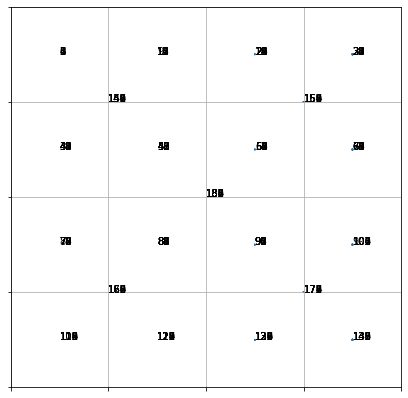

In [158]:
show_anchors(anchors,(4,4), y_first=True)

In [159]:
#anchors

#### Optimal Learning Rate 

In [160]:
# Helper function
def is_unfreeze(learner):
    '''
    Determines whether the next-to-last layer in the model is set to unfreeze or freeze
    '''
    c = 0
    for each in list(learner.model.body[-1][0].parameters()):
      if each.requires_grad: c += 1   
    if c == len(list(learner.model.body[-1][0].parameters())):
      return True 
    else:
      return False
    
  
# Find candidate learning rates, as given by points of inflection in the loass and loss-gradient curves
def find_optimal_lr(learner, noise=4, show_df=None, show_min_values=False):
    '''
    Parameters
    
      learner:  The learner (mandatory)
      
      (Optional)
      noise:   Filtering parameter, set to 4. Used to fine-tune output
      
      show_df: 'head' - Show the top 50 rows, 
               'tail' - Show the tail 50 rows
    
      show_min_values: True  - Display all values, min, and max 
                       False - Display min_loss and max_grad values
    
    Returns:
      (optimun_lr - if freeze = True)
      (Suggested top-3 lr values - if freeze = False)
      
    Author:  J. Adolfo Villalobos @ 2019  
    '''
    
    # Get loss values, corresponding gradients, and lr values from model.recorder
    loss = np.array(learner.recorder.losses[5:-5])
    loss_grad = np.gradient(loss) 

    # Transform lrs list to np array
    lrs = np.array(learner.recorder.lrs[5:-5], dtype='float32')
    
    # Create a DataFrame with the data
    data = {'loss': loss.T, 'loss_grad': loss_grad.T, 'lrs': lrs.T}
    df = pd.DataFrame(data, columns=['loss', 'loss_grad', 'lrs', 'min_loss', 'max_loss', 'min_grad', 'max_grad'])
      
    # Populate "min" and "max" columns for loss and gradient values filtering the noise with argrelextrema.     
    from scipy.signal import argrelextrema
    
    #********
    # IMPORTANT: n filters noise (sharp spikes in the data). Higher n value filters noise more aggressively. 
    # n = 4 seems to work best
    n=noise    
    #********
    
    df.min_loss = df.iloc[argrelextrema(df.loss.values, np.less_equal, order=n)[0]]['loss']
    df.max_loss = df.iloc[argrelextrema(df.loss.values, np.greater_equal, order=n)[0]]['loss']
    df.min_grad = df.iloc[argrelextrema(df.loss_grad.values, np.less_equal, order=n)[0]]['loss_grad']
    df.max_grad = df.iloc[argrelextrema(df.loss_grad.values, np.greater_equal, order=n)[0]]['loss_grad']

    # Optional: Display dataframe if show_df=True
    if show_df == 'head': print(df.head(50)) 
    elif show_df == 'tail': print(df.tail(50))     
        
    # Plot losses and loss gradients against lr values
    figs, ax = plt.subplots(1,1)
    #ax = plt.gca()
    color_loss = 'blue'
    color_grad = 'orange'
    color_green = 'green'
    color_red = 'red'

    ax.xaxis.grid(True)
    ax.set_ylabel('Loss')
    ax.set_title('Learn Rate Finder')
    ax.tick_params(axis='y', labelcolor=color_loss)
    ax.semilogx(df.lrs, df.loss, c=color_loss, label='loss' )
    
    # Define variable vertical size of the plot window, depending on the graph shape 
    u_limit = df.loss.loc[(df.lrs < 0.1)].max()*1.01
    l_limit = df.loss.loc[(df.lrs < 0.1)].min()*0.99
    ax.set_ylim([l_limit, u_limit])
   
    # Plot resulting line graphs
    ax2 = ax.twinx()
    ax2.set_ylabel('loss_grad', color= color_grad)
    ax2.semilogx(df.lrs, df.loss_grad, c = color_grad, label='loss_grad' )
    ax2.tick_params(axis='y', labelcolor = color_grad)
    
    # plot inflection points
    ax.scatter(df.lrs, df.min_loss, c = color_red, label='min_loss' )    
    ax2.scatter(df.lrs, df.min_grad, c = color_red, label='min_grad' )    
    if show_min_values:
      ax.scatter(df.lrs, df.max_loss, c = color_green, label='max_loss' )
      ax2.scatter(df.lrs, df.max_grad, c = color_green, label='max_grad' ) 
    
    # Legends
    plt.LogFormatter(labelOnlyBase=False)
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.0), ncol=3, fancybox=True, shadow=True)
    ax2.legend(loc='upper center', bbox_to_anchor=(0.5, 0.9), ncol=3, fancybox=True, shadow=True)
    plt.show()
    
    # Display resulting lr values, format varies depending of the state of the model's 
    # next-to-last layer group: set to freeze or unfreeze
    
    if is_unfreeze(learner):
      '''
      # Yellow min_grad graph
      rev_tru_idx = df.min_grad.notna()[::-1]   
      optimun_lr_upper_bound_g = df.lrs.iloc[rev_tru_idx.idxmax()] 
      rev_tru_idx[rev_tru_idx.idxmax()] = np.NaN      
      optimun_lr_lower_bound_1_g = df.lrs.iloc[rev_tru_idx.idxmax()]
      rev_tru_idx[rev_tru_idx.idxmax()] = np.NaN      
      optimun_lr_lower_bound_2_g = df.lrs.iloc[rev_tru_idx.idxmax()] 
      
      # Blue loss graph
      rev_tru_idx_loss = df.min_loss.notna()[::-1]   
      optimun_lr_upper_bound_l = df.lrs.iloc[rev_tru_idx_loss.idxmax()] 
      rev_tru_idx_loss[rev_tru_idx_loss.idxmax()] = np.NaN      
      optimun_lr_lower_bound_1_l = df.lrs.iloc[rev_tru_idx_loss.idxmax()]
      rev_tru_idx_loss[rev_tru_idx_loss.idxmax()] = np.NaN      
      optimun_lr_lower_bound_2_l = df.lrs.iloc[rev_tru_idx_loss.idxmax()] 
      '''
      # Print results and return choices of lr slice
      print('Model set to: "unfreeze" or "freeze_to:"')        
      return 
      
    else:
      print('Model set to "freeze":')
      return 

#### Preserve data classes for use in Validation and Test

In [161]:
no_classes = len(dlrs.vocab)
cls_lst = dlrs.vocab.o2i
print(F'Number of classes: {no_classes}', cls_lst)

Number of classes: 21 defaultdict(<class 'int'>, {'#na#': 0, 'aeroplane': 1, 'bicycle': 2, 'bird': 3, 'boat': 4, 'bottle': 5, 'bus': 6, 'car': 7, 'cat': 8, 'chair': 9, 'cow': 10, 'diningtable': 11, 'dog': 12, 'horse': 13, 'motorbike': 14, 'person': 15, 'pottedplant': 16, 'sheep': 17, 'sofa': 18, 'train': 19, 'tvmonitor': 20})


#### Model

In [162]:
# Model Building Blocks 
# Method used to match the shape of the output conv_ssd_layer to the ground truth's shape
def y_handoff (x, k):
    bs,nf,row,col = x.size()
    x = x.permute(0,2,3,1).contiguous()
    return x.view(bs, -1, nf//k)

# Helper functions
def conv2d(ni:int, nf:int, ks:int=3, stride:int=1, padding:int=None, bias=True, init=nn.init.kaiming_normal_) -> nn.Conv2d:
    '''Create and initialize `nn.Conv2d` layer. `padding` defaults to `ks//2`.'''
    if padding is None: padding = ks//2
    return init_default(nn.Conv2d(ni, nf, kernel_size=ks, stride=stride, padding=padding, bias=bias), init)

# Conv2d Layer
def conv2d_layer(ni:int, nf:int, ks:int=3, stride:int=2, padding:int=1, bias:bool=None, 
               norm_type:Optional[NormType]=NormType.Batch,  
               init:Callable=nn.init.kaiming_normal_, self_attention:bool=False):
    ''' Create a set of conv2 (`ni` to `nf`), batchnorm, and ReLU  (if `bn`) layers.'''
    if padding is None: padding = (ks-1)//2 
    bn = norm_type in (NormType.Batch, NormType.BatchZero)
    if bias is None: bias = not bn
    conv = init_default(nn.Conv2d(ni, nf, kernel_size=ks, bias=bias, stride=stride, padding=padding), init)
    layers = [conv]
    layers.append(nn.BatchNorm2d(nf))
    layers.append(nn.ReLU(True))     
    if self_attention: layers.append(SelfAttention(nf))
    return nn.Sequential(*layers)

# Standard convolution with stride=2 to halve the size of the image. OK
class conv2_std_layer(nn.Module):
    def __init__(self, n_in, n_out, stride=2, drop=0.1):   
        super().__init__()
        self.cnv = conv2d_layer(n_in, n_out, stride=stride, padding=1, bias=None)
        self.drp = nn.Dropout(drop)
        
    def forward(self, x):
        return self.drp(self.cnv(x))

# SSD convolution that camptures bounding box and class
class conv2_ssd_layer(nn.Module):
    def __init__(self, ni, k, no_cls, bias_amt=-4):
        super().__init__()
        self.k = k 
        self.no_cls = no_cls
        self.bias_amt = bias_amt
        self.conv_class = conv2d(ni=ni, nf=(self.no_cls*self.k), padding=1)
        self.conv_bbox = conv2d(ni=ni, nf=(4 * self.k),  padding=1)  
        self.conv_class.bias.data.zero_().add_(self.bias_amt)
           
    def forward(self, x):
        label = self.conv_class(x)
        box = self.conv_bbox(x)
        return [y_handoff(box, self.k), y_handoff(label, self.k)]

In [163]:
# SSD Model
class ssd_model(nn.Module):
    def __init__(self, arch=resnet50, k=9 , drop=0.4, no_cls=21, bias_amt=-4 ):
        super().__init__()
        self.k = k
        self.no_cls = no_cls
        self.bias_amt = bias_amt

        self.body = create_body(arch)

        self.drop = nn.Dropout(0.25)   # it was 0.25
        
        self.std_conv_0 = conv2_std_layer(num_features_model(self.body), 256, stride=1)
  
        #This conv2d compensates for Progressive Sizing settings so that the final layer is 1 x 1
        self.img_size = conv2d( 256, 256, padding=0)  # image size adjuster

        # Dimension-reducing  layers
        self.std_conv_1 = conv2_std_layer(256, 256, drop=drop, stride=2) # 4 by 4 layer  128
        self.std_conv_1_1 = conv2d_layer(256, 256, stride=1)  # Booster layer
        self.std_conv_2 = conv2_std_layer(256, 256, drop=drop, stride=2) # 2 by 2 layer  64
        self.std_conv_1_2 = conv2d_layer(256, 256, stride=1)  # Booster layer
        self.std_conv_3 = conv2_std_layer(256, 256, drop=drop, stride=2) # 1 by 1 layer  32
        # SSD layers
        self.ssd_conv_1 = conv2_ssd_layer(256, k=self.k, no_cls=self.no_cls, bias_amt=self.bias_amt) #256x189
        self.ssd_conv_2 = conv2_ssd_layer(256, k=self.k, no_cls=self.no_cls, bias_amt=self.bias_amt)
        self.ssd_conv_3 = conv2_ssd_layer(256, k=self.k, no_cls=self.no_cls, bias_amt=self.bias_amt)
        
    def forward(self, xb):
        xb = self.drop(F.relu(self.body(xb)))
        xb = self.std_conv_0(xb)
        xb = self.img_size(xb)
        xb = self.std_conv_1(xb)
        xb = self.std_conv_1_1(xb)
        bb1, cls1 = self.ssd_conv_1(xb) # 4 x 4
        xb = self.std_conv_2(xb)
        xb = self.std_conv_1_2(xb)
        bb2, cls2 = self.ssd_conv_2(xb) # 2 x 2
        xb = self.std_conv_3(xb)     
        bb3, cls3  = self.ssd_conv_3(xb) # 1 x 1

        return [torch.cat([bb1, bb2, bb3], dim=1), 
                torch.cat([cls1, cls2, cls3], dim=1)]

#### Loss Function

In [164]:
# Helper function
# Map to Ground Truth.
def map_to_gt(overlaps):
    # For each gt_bbox, find the default box with maximun overlap
    prior_overlap, prior_idx = overlaps.max(dim=1)
    # For each default box, find gt_bboxes with overlap surpassing the threshold
    sec_overlap, sec_idx = overlaps.max(dim=0)
    # The gt_bboxes in prior_overlap must surpass the threshold
    sec_overlap[prior_idx] = 4.99
    # sec_idx contains the indecis of their respective rows
    for i,o in enumerate(prior_idx): 
        sec_idx[o] = i
    # sec_overlap contains the IOU index for each default box
    # sec_idx contains the row with the largest overlap
    # prior_overlap contains values that surpass the threshold
    return sec_overlap,sec_idx

# Focal loss implementation
def get_weight(x,t):
    x,t = x.cpu(), t.cpu()
    p = x.sigmoid()
    pt = p * t + (1 - p) * (1 - t)
    w = ALPHA*t + (1 - ALPHA) * (1 - t)
    return w * (1 - pt).pow(GAMMA)
    
# Classification loss computation, based on Binary Cross Entrophy with Logits
def bceloss(pred,target,num_classes):

    t = torch.eye(num_classes)[target.detach().cpu()][:,1:]
    p = pred[:,1:]
    
    w = get_weight(p,t) 

    return  F.binary_cross_entropy_with_logits(p.cpu(), t, weight = w.detach(), reduction='mean') / (num_classes - 1)
    #return  F.multilabel_soft_margin_loss( p.cpu(), t, weight = w.detach(), reduction='mean') / (num_classes - 1)


# Bounding-box loss computation, based on fixed Anchor Boxes and L1 Loss
def single_ssd_loss(pbox,plabel,box,label):
    # IOU Threshold. Keep overlaps with iou above this level
    threshold = 0.4
    
    # Compute the jaccard (overlap) between ground truth and anchor boxes
    anchor_box = anchors
    base_box = cthw2corners(anchor_box) # Map anchors into Fastai format: top-left and bottom-right coordinates
    #  un_pad
    bbox, clas = un_pad(box, label) # Filter all non-zero boxes
    overlaps = iou(bbox,base_box.to(device))  # Calculate iou for anchor and target box
    try:
        gt_overlaps, gt_idx = map_to_gt(overlaps)
    except:
        return 0,0

    # Map gt_idx back to classes for multi label classfication
    gt_clas = clas[gt_idx]

    # Positive predictions have overlaps greater than 0.4
    pos = gt_overlaps > threshold

    #************************************************
    # Fix for "mask inversion problem" in PyTorch 1.2 (10/22/19)
    gt_clas[~pos] = len(dlrs.vocab)
    # ***********************************************

    gt_label = [o.item() if o < len(dlrs.vocab) else 0 for o in gt_clas.detach()] #Ground truth labels
    pos_idx = torch.nonzero(pos)[:,0] 
    gt_bbox = bbox[gt_idx]  # Selected ground truth box
    
    # Map predicted bounding box to anchor with offset and convert it to Fastai format: top-left and bottom-right coordinates
    p_final_box = act_to_bbox(pbox,anchor_box.to(device)) 
    
    #L1 loss calculation
    loc_loss = ((p_final_box[pos_idx] - gt_bbox[pos_idx]).abs()).mean()
    
    #Multi classification
    label_loss = bceloss(plabel,tensor(gt_label),len(dlrs.vocab))
    return loc_loss,label_loss

# Loop through each of the y_hat and y pairs 
def ssd_loss(preds, *targets, print_it=False):
    # *****************************
    # Fastai2 uses de convention to write coordinates in the order of (x,y). Fastai1 uses the convention order of (y,x)
    # This system was originally written for Fastai1. So, to make it work in Fastai2, we flip the coordinates incoming 
    # to the loss function from xy, to yx
    # ******************************
    batch_loc_loss, batch_label_loss = 0., 0.
    bbl, lbl = [], []
    #print(F'Preds[0] : {preds[0].size()}, Preds[1] : {preds[1].size()} Targets : {targets[0].size()}')
    for p_box, p_label, box, label in zip(*preds,*targets):
        #print(F'p_box : {p_box.shape} , p_label : {p_label.shape}')
        # Swaping coordinates
        p_box = swap_xy_coords(p_box)   
        box   = swap_xy_coords(box)
        # *****
        loc_loss, label_loss = single_ssd_loss(p_box, p_label, box, label)
       
        bbl.append(loc_loss) 
        lbl.append(label_loss)
    #total_loss = batch_loc_loss  + batch_label_loss.to(device) 
    total_loss = torch.mean(torch.stack(bbl),dim=0) + torch.mean(torch.stack(lbl),dim=0).to(device)
    if print_it: print(torch.mean(torch.stack(bbl),dim=0), batch_label_losstorch.mean(torch.stack(lbl),dim=0))
    #if print_it: print(bbl.mean(dim=0, keepdim=True), lbl.mean(dim=0, keepdim=True))
    return total_loss
# loss function
loss_func = ssd_loss

#### Batch Activation Filtering

In [165]:
# Decodes bounding boxes and classes and filters them thwough MNS. Returns uniform-sized box and score tensors 
class BatchPredict (Callback):
  ''' For each batch, predict bounding boxes and classes and returns uniform-sized box and score tensors.
      This class works with the Learner's cbs callback. The calling sequence is : cbs=[BatchPredict]'''

  def __init__(self, anchrs:Tensor, threshold:Float=0.5 ):
    self.threshold = threshold
    self.anchrs = anchrs

  def after_loss(self):
    ''' This method is called by the cbs callback.
        Input:  list of boxes and scores read from self.learn.pred
        Output: list of uniform-sized tensors containing boxes and scores
    '''
    if self.training: return                              # the class activates during the validation cycle only   
 
    one_batch_boxes, one_batch_scores = activation_decode_mns(anchrs=self.anchrs, activs=self.learn.pred, threshold=self.threshold)
    self.learn.pred = to_device((one_batch_boxes, one_batch_scores))

#### Learner

In [166]:
# Object Detection Learner
from fastai2.vision import learner
@log_args(to_return=True, but_as=Learner.__init__)
@delegates(Learner.__init__)
def obj_detect_learner(dls, arch, model=None, custom_head=None, loss_func=None, pretrained=True, cut=None, splitter=None,
                y_range=None, config=None, n_out=None,  normalize=True, concat_pool=True,cbs=None, fp16=False, **kwargs):
    ''' Build an object detection convnet learner. You can chhose to supply:
        1) a custom head (which will be combined with the body), or
        2) a model already packaged with a body and a head '''

    if config is None: config = {}
    meta = model_meta.get(arch,  learner._default_meta)
    if normalize: learner._add_norm(dls, meta, pretrained)
    
    #if model is None:
    #  if n_out is None: n_out = get_c(dls)
    #  assert n_out, "`n_out` is not defined, and could not be infered from data, set `dls.c` or pass `n_out`"
    #  if y_range is None and 'y_range' in config: y_range = config.pop('y_range')
    #  model = create_obj_det_model(arch, n_out,  ifnone(cut, meta['cut']), pretrained,  custom_head=custom_head, concat_pool=True, y_range=y_range, **config)
    
    learn = Learner(dls, model, loss_func=loss_func, splitter=ifnone(splitter, meta['split']), cbs=cbs,  **kwargs)
    if fp16: learn.to_fp16() 
    if pretrained: learn.freeze()

    return learn

#### Object Detection Learner

In [167]:
# Model split and model learner
def run_learner():
  def model_split(m): return L(m.body[0], m.body[1], m.body[2], m.body[3], m.body[4], m.body[5], m.body[6], m.body[7], m.drop).map(params)
  mod = ssd_model(arch=ARCH, k=k, no_cls=no_classes, drop=0.25, bias_amt=-3 )
  #learn = obj_detect_learner(dls=dlrs,  arch=ARCH,  model=mod, loss_func=loss_func, splitter=model_split, 
  #        concat_pool=False, custom_head=None, cbs=[BatchPredict(anchors)], fp16=True)
  learn = obj_detect_learner(dls=dlrs,  arch=ARCH,  model=mod, loss_func=loss_func, splitter=model_split, 
          concat_pool=False, custom_head=None,  fp16=True)
  return learn

  learn = run_learner()

In [ ]:
learn.summary()

#### Show results

In [124]:
# I wrote my own show_results method because the Fastai version is broken

def infer_and_show_results(x:Learner, ds_idx=1, dl=None, max_n=9, shuffle=True, **kwargs):
  ''' Display resulting images from a dataset
      input
          ds_idx:     Index of dataloader 
          dl:         Data loader, if one is given instead of ds_index
          max_n:      Maximun number of images to display
          shuffle:    if True, shufle images (only works if ds_idx is given)'''
  learn.training = False                                # Set the learner to Validation mode

  if dl is None: dl = x.dls[ds_idx].new(shuffle=True)   # Create a new dataloader from the given ds_idx
  im, b, c = dl.one_batch()                             # Create one batch
 
  b = TensorBBox(fake_na_boxes(flip_on_y_axis(rotate_90_plus(b)))) # A Hack! The standard sow_results rotates boxes by 90 counterclocwise. This hack remedies this condition

  btch = (im, b, c)                                      # Restore batch
  _,_,preds = x.get_preds(dl=[btch], with_decoded=True)  # Calculate predictions (triggers batch predictions)
  
  #import pdb;pdb.set_trace()  #breakpoint()   #
  #save_file(btch, 'btch')
  #save_file(preds, 'preds')

  x.dls.show_results(btch, preds, max_n=max_n, figsize=(11,11), **kwargs)    # Show results

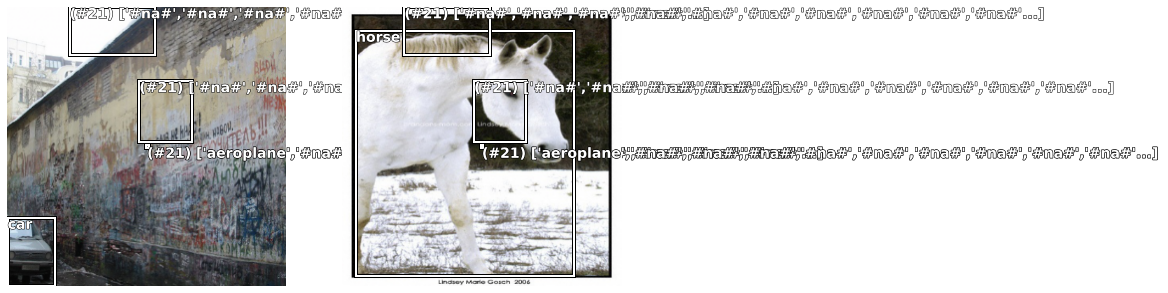

In [125]:
learn.cbs[3].threshold=0.999
infer_and_show_results(learn,  max_n=2)

#### Show Batch

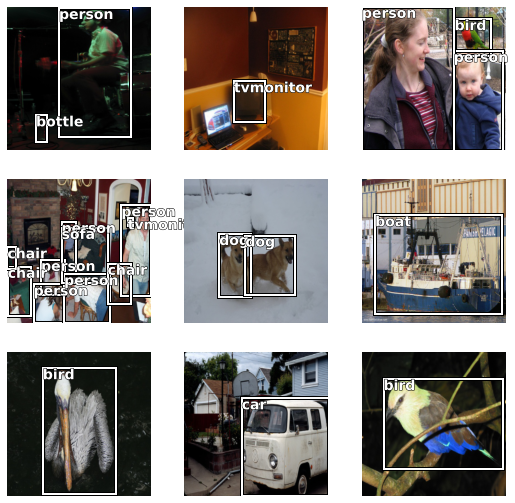

In [126]:
learn.dls.valid.show_batch(figsize=(9,9))

#### Save classes for offline inference

In [127]:
# Save Classes in a file for use later in the section that predicts external images (which can be run on a separate computer)
with open(F'/content/gdrive/My Drive/ssd_classes', 'wb') as fp:
    pickle.dump(no_classes, fp)
    pickle.dump(cls_lst, fp)

#### Fit

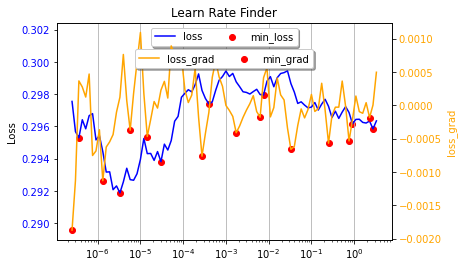

Model set to "freeze":


In [168]:
# Find Finder
learn.lr_find( show_plot=False)
# Find Optimal Learning Rates
lr =  find_optimal_lr(learn, noise=4)

In [169]:
learn.fit_one_cycle(10, slice(1.0E-01) )
learn.save(F'/content/gdrive/My Drive/ssd_freeze_1_aug')

epoch,train_loss,valid_loss,time
0,0.297132,0.236123,04:00
1,0.292536,0.230775,03:57
2,0.280952,0.217667,03:58
3,0.266514,0.207039,03:56
4,0.256632,0.203059,03:57
5,0.247847,0.200078,03:58
6,0.245116,0.199837,03:58
7,0.241276,0.198197,04:00
8,0.242706,0.199064,04:03
9,0.240143,0.197962,04:01


In [ ]:
learn.recorder.plot_loss()

In [176]:
learn.load(F'/content/gdrive/My Drive/ssd_freeze_1_aug', strict=True)

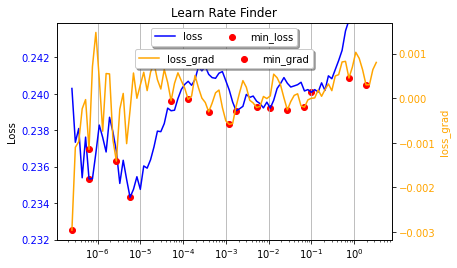

Model set to "freeze":


In [174]:
learn.freeze()
learn.lr_find( show_plot=False)
lr =  find_optimal_lr(learn, noise=4)

In [175]:
# Best results
learn.fit_one_cycle(5, slice(5.0E-5) )
learn.save(f'/content/gdrive/My Drive/ssd_freeze_2_aug')

epoch,train_loss,valid_loss,time
0,0.236479,0.197833,03:56
1,0.236992,0.197729,04:00
2,0.237969,0.197817,03:59
3,0.236947,0.197518,04:01
4,0.240341,0.198722,03:56


In [ ]:
learn.recorder.plot_loss()

In [177]:
learn.load(f'/content/gdrive/My Drive/ssd_freeze_2_aug', strict=True)

/usr/local/lib/python3.6/dist-packages/scipy/signal/_peak_finding.py:77: RuntimeWarning: invalid value encountered in less_equal
  results &= comparator(main, plus)
/usr/local/lib/python3.6/dist-packages/scipy/signal/_peak_finding.py:78: RuntimeWarning: invalid value encountered in less_equal
  results &= comparator(main, minus)
/usr/local/lib/python3.6/dist-packages/scipy/signal/_peak_finding.py:77: RuntimeWarning: invalid value encountered in greater_equal
  results &= comparator(main, plus)
/usr/local/lib/python3.6/dist-packages/scipy/signal/_peak_finding.py:78: RuntimeWarning: invalid value encountered in greater_equal
  results &= comparator(main, minus)


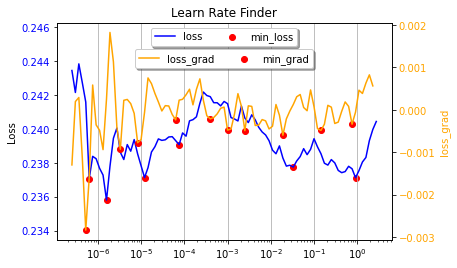

Model set to: "unfreeze" or "freeze_to:"


In [178]:
learn.unfreeze()
learn.lr_find( show_plot=False)
lr =  find_optimal_lr(learn, noise=4)

In [179]:
learn.fit_one_cycle(10, slice(2.0E-02) )
learn.save(f'/content/gdrive/My Drive/ssd_unfreeze_3_aug')

epoch,train_loss,valid_loss,time
0,0.234823,0.199642,04:09
1,0.238710,0.547114,04:10
2,0.238585,0.197405,04:09
3,0.230856,0.554700,04:08
4,0.229970,0.237140,04:07
5,0.229590,0.225201,04:11
6,0.229327,0.211377,04:10
7,0.225858,0.207134,04:07
8,0.224576,0.202720,04:05
9,0.227510,0.204210,04:05


In [ ]:
learn.load(F'/content/gdrive/My Drive/ssd_unfreeze_3_aug', strict=True)

In [ ]:
learn.recorder.plot_loss()

/usr/local/lib/python3.6/dist-packages/scipy/signal/_peak_finding.py:77: RuntimeWarning: invalid value encountered in less_equal
  results &= comparator(main, plus)
/usr/local/lib/python3.6/dist-packages/scipy/signal/_peak_finding.py:78: RuntimeWarning: invalid value encountered in less_equal
  results &= comparator(main, minus)
/usr/local/lib/python3.6/dist-packages/scipy/signal/_peak_finding.py:77: RuntimeWarning: invalid value encountered in greater_equal
  results &= comparator(main, plus)
/usr/local/lib/python3.6/dist-packages/scipy/signal/_peak_finding.py:78: RuntimeWarning: invalid value encountered in greater_equal
  results &= comparator(main, minus)


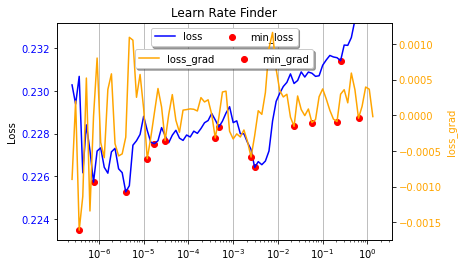

Model set to: "unfreeze" or "freeze_to:"


In [183]:
learn.unfreeze()
learn.lr_find( show_plot=False)
lr =  find_optimal_lr(learn, noise=4)

In [184]:
learn.fit_one_cycle(10, slice(4.0E-05) )
learn.save(f'/content/gdrive/My Drive/ssd_unfreeze_4_aug')

epoch,train_loss,valid_loss,time
0,0.226658,0.206487,04:08
1,0.226596,0.203972,04:09
2,0.226985,0.203966,04:09
3,0.225678,0.203230,04:08
4,0.226169,0.200766,04:06
5,0.227007,0.204603,04:05
6,0.227711,0.206884,04:06
7,0.227216,0.201222,04:05
8,0.227591,0.203691,04:08
9,0.226429,0.202964,04:06


#### Progressive Resizing

In [ ]:
# Parameters
SZ = 400

In [ ]:
 # Create Data Loaders
 dlrs, data = get_data(BS, SZ, AUG_SZ)
 

In [ ]:
# Modify Model to adapt to new iage size


In [ ]:
# Run Learner
 learn = run_learner()

In [ ]:
learn.summary()

In [ ]:
data.summary(ds_source/'train')

In [ ]:
learn.unfreeze()
learn.lr_find( show_plot=False)
lr =  find_optimal_lr(learn, noise=4)

In [ ]:
learn.fine_tune(3, 1.5E-02)
learn.save(f'/content/gdrive/My Drive/ssd_basic_3')

In [ ]:
learn.fine_tune(5, 1.5E-02)
learn.save(f'/content/gdrive/My Drive/ssd_basic_3')

In [ ]:
learn.save(f'/content/gdrive/My Drive/ssd_basic_3')

In [ ]:
learn.load(F'/content/gdrive/My Drive/ssd_basic_3', strict=True)

In [ ]:
learn.unfreeze()
learn.lr_find( show_plot=False)
lr =  find_optimal_lr(learn, noise=4)

In [ ]:
learn.fine_tune(5, 2.0E-04)
learn.save(f'/content/gdrive/My Drive/ssd_basic_4')

In [ ]:
learn.load(F'/content/gdrive/My Drive/ssd_basic_4', strict=True)

#### Show Results

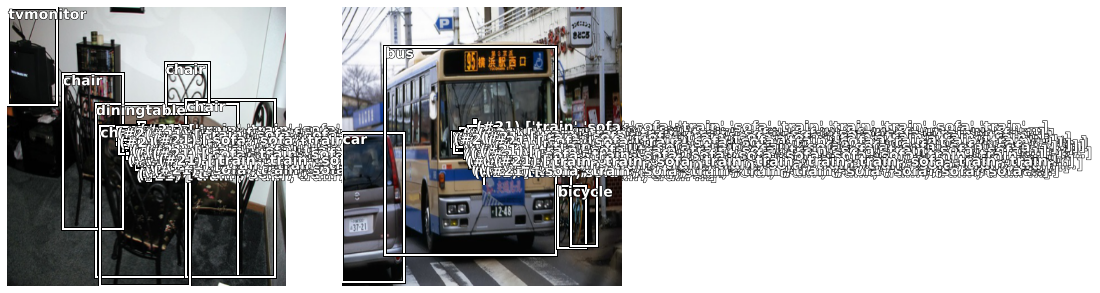

In [192]:
learn.cbs[3].threshold=0.99999
infer_and_show_results(learn,  max_n=2)


#### Predict from valid dataset

In [ ]:
learn.load(F'/content/gdrive/My Drive/ssd_unfreeze_3_aug', strict=True)

In [ ]:
# Get an image from the valid dataset
it = iter(learn.dls.valid)

In [ ]:
nxt_batch = next(it)

In [ ]:
imgs_val, bxs_val, cls_val = nxt_batch

In [ ]:
imgs_val.shape, bxs_val.shape, cls_val.shape     # Outtput of validation dl: imgs, boxes, and labels

(torch.Size([32, 3, 280, 280]), torch.Size([32, 11, 4]), torch.Size([32, 11]))

In [ ]:
# Predict results from images in FASTAI format -1. + 1 
def get_preds(im):
  learn.model.eval()
  learn.model.to(torch.float32)
  with torch.no_grad():
    out= learn.model(im)
  raw_bboxes = learn.dls.valid.loss_func.activation(out[0])   # 0 - boxes, 1 - classes, 
  raw_classes = learn.dls.valid.loss_func.activation(out[1])   # 0 - boxes, 1 - classes, 
  class_msks = learn.dls.valid.loss_func.decodes(raw_classes)
  return [raw_bboxes,raw_classes]

In [ ]:
preds = get_preds(imgs_val)

In [ ]:
p_bxs, p_clss = preds

In [ ]:
p_bxs.shape, p_clss.shape

(torch.Size([32, 189, 4]), torch.Size([32, 189, 21]))

#### Examples of Image Display

In [ ]:
# Display image with accompanying bounding boxes and labels
def show_lbld_img(t_fn, t_bbox):
  ''' Show labeled image, given the following paraeters:
      t_fn : image file path
      t_bbox : list with bounding box(s) and label(s) '''

  if (not isinstance(t_fn, PILImage)) or (not isinstance(t_fn, PIL.Image.Image)): 
    t_img = (PILImage.create)(t_fn) 
  else:
    t_img = t_fn
  t_bbox = LabeledBBox(TensorBBox(t_bbox[0]), t_bbox[1])
  ctx = t_img.show(figsize=(6,6))
  t_bbox.show(ctx=ctx)

idx = 16

#  Select an image by its index, load and displai it
imgs, lbl_bbs = get_annotations(ds_source/'test.json')
t_fn, t_bbox = ds_source/'test'/imgs[idx], lbl_bbs[idx]
print(t_bbox[0][0])
print(t_fn)
show_lbld_img(t_fn, t_bbox)

# Alternative way
img = Transform(PILImage.create)(t_fn)
show_image(img)

##### Old Inference

In [ ]:
# Filter images with NMS given its index
def show_filtered_img_by_ndx(idx, im, d_classes, act_bb, act_cls):

    # make a copy of the lass list
    import copy
    d_cl = copy.deepcopy(d_classes )
    dt = list(d_cl.keys())
    d_cl = np.array(dt)

    # Process NMF 
    tot_bx, tot_cls, scrd_cls_lst = process_nmf(idx, d_cl, act_bb, act_cls)  # Filter dupplicate boxes
    if tot_bx is None: return 
    
    print(tot_bx, tot_cls, scrd_cls_lst)

    # Compose the image, bouding boxes, and classes for display
    #show_lbld_img(img, [tot_bx, tot_cls])
    #p_img_box = ImageBBox.create(224,224,tot_bx.cpu(),tot_cls.cpu(),classes=scrd_cls_lst,scale=False)
  
    # Display resulting image, selected bounding boxes, and class labels
    #fig,axes = plt.subplots(1,1,figsize=(10,10))
    # Prepare ground-truth image for display 
    #img = vision.Image(denormalize(xb[idx],*tensor(imagenet_stats)))  
    #img.show(ax=axes,y=p_img_box,title='Prediction', color=colr_list[11])

In [ ]:
#Filter Image Sets
for i in range(0,1): show_filtered_img_by_ndx(i, im, learn.dls.vocab.o2i, p_bb, p_lb)

#### Old Batch Predict Class

In [ ]:
# Decodes bounding boxes and classes and filters them thwough MNS. Returns uniform-sized box and score tensors 
class BatchPredict (Callback):
  ''' For each batch, predict bounding boxes and classes and returns uniform-sized box and score tensors.
      This class works with the Learner's cbs callback. The calling sequence is : cbs=[BatchPredict]'''

  def __init__(self, anchrs:Tensor, threshold:Float=0.5 ):
    self.threshold = threshold
    self.anchrs = anchrs
    self.once=True

  def after_loss(self):
    ''' This method is called by the cbs callback.
        Input:  list of boxes and scores read from self.learn.pred
        Output: list of uniform-sized tensors containing boxes and scores
    '''
    if self.training: return                              # the class activates during the validation cycle only   
    p_bboxes, p_classes = self.learn.pred                 # Read p_bboxes: [32, 189,4] Torch.Tensor and  p_classes: [32, 189, 21]  Torch.Tensor from self.learn.pred  
    print('Hi, there. I just ran')
    
    #scores = torch.sigmoid(p_classes)                    # Calculate the confidence levels, scores, for class predictions [0, 1] 
    scores = torch.softmax(p_classes, -1)                  # Calculate the confidence levels, scores, for class predictions [0, 1] - Probabilistic 
    
    offset_boxes = activ_decode(p_bboxes, self.anchrs)    # Return anchors + anchor offsets wiith format (batch, No Items in Batch, 4)

    # For each item in batch, and for each class in the item, filter the image by passing it through NMS. Keep preds with IOU > thresshold
    one_batch_boxes = []; one_batch_scores = []; one_batch_cls_pred = []  # Agregators at the bath level

    for i in range(p_classes.shape[0]):                   # For each image in batch ...
      batch_p_boxes = offset_boxes[i]                     # box preds for the current batch
      batch_scores = scores[i]                            # Keep scores for the current batch
      max_scores, cls_idx = torch.max(batch_scores, 1 )   # Keep batch class indexes
      bch_th_mask = max_scores > self.threshold           # Threshold mask for batch
      bch_keep_boxes = batch_p_boxes[bch_th_mask]         #  "
      bch_keep_scores = batch_scores[bch_th_mask]         #  "
      bch_keep_cls_idx = cls_idx[bch_th_mask]

      # Agregators per image in a batch
      img_boxes = []                                      # Bounding boxes per image
      img_scores = []                                     # Scores per image
      img_cls_pred = []                                   # Class predictons per image
 
      for c in range (1,no_classes):                      # Loop through each class

        cls_mask = bch_keep_cls_idx==c                    # Keep masks for the current class
        if cls_mask.sum() == 0: continue                  # Weed out images with no positive class masks

        cls_boxes = bch_keep_boxes[cls_mask]              # Keep boxes per image
        cls_scores = bch_keep_scores[cls_mask].max(dim=1)[0]    # Keep class scores for the current image
    
        nms_keep_idx = torchvision.ops.nms(cls_boxes, cls_scores, iou_threshold=0.5)   # Filter images by passing them through NMS

        img_boxes += [*cls_boxes[nms_keep_idx]]           # Agregate cls_boxes into tensors for all classes
        box_stack = torch.stack(img_boxes,0)              # Transform individual tensors into a single box tensor 
        img_scores += [*cls_scores[nms_keep_idx]]         # Agregate cls_scores into tensors for all classes 
        score_stack = torch.stack(img_scores, 0)          # Transform individual tensors into a single score tensor 

        img_cls_pred += [*tensor([c]*len(nms_keep_idx))]    # What is this??
        cls_pred_stack = torch.stack(img_cls_pred, 0)
        
        batch_mask = score_stack > self.threshold         # filter final lists tto be greater than threshold
        box_stack = box_stack[batch_mask]                 #   "
        
        score_stack = score_stack[batch_mask]             #   "
        cls_pred_stack = cls_pred_stack[batch_mask]       #   "
      if 'box_stack' not in locals(): continue            # Failed to find any valid classes
      one_batch_boxes.append(box_stack)                   # Agregate bounding boxes for the batch  
      one_batch_scores.append(score_stack)                # Agregate scores for the batch 
      one_batch_cls_pred.append(cls_pred_stack)

    # Pad individual box and score tensors into uniform-sized box and score tensors of shapes: (batch, no 0f items in batch, 4) and  (batch, no 0f items in batch, 21)
    one_batch_boxes, one_batch_scores = pad_output(one_batch_boxes, one_batch_scores, one_batch_cls_pred)

    # Print statements for final debugging of shaw_results
    #if self.once: 
    #  print(F'one_batch_boxes: {one_batch_boxes}')
    #  for each in one_batch_scores:print(F'{each}')
    #self.once=False
    
    self.learn.pred = to_device((one_batch_boxes, one_batch_scores))

In [ ]:
# Force Fastai to run on the CPU only
#device = torch.device('cpu') 
#defaults.device = 'cpu'